In [1]:
import os
os.chdir("/Users/a12711/Documents/ゼロから作るDeepLearning2/deep-learning-from-scratch-2-master")
os.getcwd()

'/Users/a12711/Documents/ゼロから作るDeepLearning2/deep-learning-from-scratch-2-master'

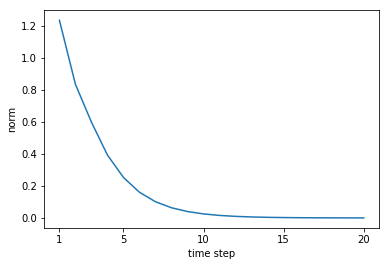

In [7]:
import numpy as np
import matplotlib.pyplot as plt

N = 2
H = 3
T = 20

dh = np.ones((N, H))
np.random.seed(3)
Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)
    
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

In [10]:
import numpy as np


dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate
            
print('before:', dW1.flatten())
clip_grads(grads, max_norm)
print('after:', dW1.flatten())

before: [2.77977507 4.54622076 2.05410345 2.01378711 5.1403506  0.87229369
 4.83585532 3.62176212 7.07686622]
after: [0.66651711 1.09006443 0.4925201  0.4828533  1.23252117 0.20915313
 1.15951119 0.86840351 1.69684679]


In [14]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b
        
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next
    
        

In [15]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')
            
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h
            
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]
        
        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0
        
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs
    
    def set_state(self, h, c=None):
        self.h, self.c = h, c
        
    def reset_state(self):
        self.h, self.c = None, None
        

In [7]:
import sys
sys.path.append('..')
from common.time_layers import *
import pickle

class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(D, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()
        
    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
    
    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)
    

Done


| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 10002.25


| epoch 1 |  iter 21 / 1327 | time 5[s] | perplexity 2984.40


| epoch 1 |  iter 41 / 1327 | time 11[s] | perplexity 1205.23


| epoch 1 |  iter 61 / 1327 | time 16[s] | perplexity 967.53


| epoch 1 |  iter 81 / 1327 | time 22[s] | perplexity 786.30


| epoch 1 |  iter 101 / 1327 | time 28[s] | perplexity 660.96


| epoch 1 |  iter 121 / 1327 | time 34[s] | perplexity 660.88


| epoch 1 |  iter 141 / 1327 | time 40[s] | perplexity 601.03


| epoch 1 |  iter 161 / 1327 | time 46[s] | perplexity 568.46


| epoch 1 |  iter 181 / 1327 | time 52[s] | perplexity 590.27


| epoch 1 |  iter 201 / 1327 | time 58[s] | perplexity 503.20


| epoch 1 |  iter 221 / 1327 | time 64[s] | perplexity 488.60


| epoch 1 |  iter 241 / 1327 | time 70[s] | perplexity 438.68


| epoch 1 |  iter 261 / 1327 | time 76[s] | perplexity 464.52


| epoch 1 |  iter 281 / 1327 | time 82[s] | perplexity 455.89


| epoch 1 |  iter 301 / 1327 | time 88[s] | perplexity 389.13


| epoch 1 |  iter 321 / 1327 | time 94[s] | perplexity 343.11


| epoch 1 |  iter 341 / 1327 | time 100[s] | perplexity 404.77


| epoch 1 |  iter 361 / 1327 | time 105[s] | perplexity 405.11


| epoch 1 |  iter 381 / 1327 | time 112[s] | perplexity 331.85


| epoch 1 |  iter 401 / 1327 | time 118[s] | perplexity 347.42


| epoch 1 |  iter 421 / 1327 | time 124[s] | perplexity 345.96


| epoch 1 |  iter 441 / 1327 | time 130[s] | perplexity 332.58


| epoch 1 |  iter 461 / 1327 | time 137[s] | perplexity 328.02


| epoch 1 |  iter 481 / 1327 | time 143[s] | perplexity 302.03


| epoch 1 |  iter 501 / 1327 | time 150[s] | perplexity 310.06


| epoch 1 |  iter 521 / 1327 | time 156[s] | perplexity 298.60


| epoch 1 |  iter 541 / 1327 | time 163[s] | perplexity 319.37


| epoch 1 |  iter 561 / 1327 | time 170[s] | perplexity 285.45


| epoch 1 |  iter 581 / 1327 | time 176[s] | perplexity 257.83


| epoch 1 |  iter 601 / 1327 | time 183[s] | perplexity 333.62


| epoch 1 |  iter 621 / 1327 | time 189[s] | perplexity 306.08


| epoch 1 |  iter 641 / 1327 | time 196[s] | perplexity 284.16


| epoch 1 |  iter 661 / 1327 | time 203[s] | perplexity 269.26


| epoch 1 |  iter 681 / 1327 | time 209[s] | perplexity 227.33


| epoch 1 |  iter 701 / 1327 | time 216[s] | perplexity 249.17


| epoch 1 |  iter 721 / 1327 | time 222[s] | perplexity 258.45


| epoch 1 |  iter 741 / 1327 | time 229[s] | perplexity 219.69


| epoch 1 |  iter 761 / 1327 | time 235[s] | perplexity 231.39


| epoch 1 |  iter 781 / 1327 | time 241[s] | perplexity 218.07


| epoch 1 |  iter 801 / 1327 | time 247[s] | perplexity 240.89


| epoch 1 |  iter 821 / 1327 | time 253[s] | perplexity 223.35


| epoch 1 |  iter 841 / 1327 | time 259[s] | perplexity 226.79


| epoch 1 |  iter 861 / 1327 | time 266[s] | perplexity 220.48


| epoch 1 |  iter 881 / 1327 | time 272[s] | perplexity 205.30


| epoch 1 |  iter 901 / 1327 | time 278[s] | perplexity 252.03


| epoch 1 |  iter 921 / 1327 | time 284[s] | perplexity 224.18


| epoch 1 |  iter 941 / 1327 | time 290[s] | perplexity 225.87


| epoch 1 |  iter 961 / 1327 | time 296[s] | perplexity 242.21


| epoch 1 |  iter 981 / 1327 | time 302[s] | perplexity 226.81


| epoch 1 |  iter 1001 / 1327 | time 307[s] | perplexity 191.07


| epoch 1 |  iter 1021 / 1327 | time 314[s] | perplexity 224.49


| epoch 1 |  iter 1041 / 1327 | time 320[s] | perplexity 205.12


| epoch 1 |  iter 1061 / 1327 | time 326[s] | perplexity 193.59


| epoch 1 |  iter 1081 / 1327 | time 332[s] | perplexity 164.85


| epoch 1 |  iter 1101 / 1327 | time 338[s] | perplexity 191.79


| epoch 1 |  iter 1121 / 1327 | time 345[s] | perplexity 225.02


| epoch 1 |  iter 1141 / 1327 | time 351[s] | perplexity 205.44


| epoch 1 |  iter 1161 / 1327 | time 357[s] | perplexity 196.99


| epoch 1 |  iter 1181 / 1327 | time 363[s] | perplexity 187.24


| epoch 1 |  iter 1201 / 1327 | time 370[s] | perplexity 160.96


| epoch 1 |  iter 1221 / 1327 | time 376[s] | perplexity 158.17


| epoch 1 |  iter 1241 / 1327 | time 382[s] | perplexity 186.28


| epoch 1 |  iter 1261 / 1327 | time 388[s] | perplexity 169.62


| epoch 1 |  iter 1281 / 1327 | time 394[s] | perplexity 175.53


| epoch 1 |  iter 1301 / 1327 | time 400[s] | perplexity 217.97


| epoch 1 |  iter 1321 / 1327 | time 406[s] | perplexity 208.16


| epoch 2 |  iter 1 / 1327 | time 409[s] | perplexity 221.11


| epoch 2 |  iter 21 / 1327 | time 415[s] | perplexity 200.35


| epoch 2 |  iter 41 / 1327 | time 420[s] | perplexity 187.71


| epoch 2 |  iter 61 / 1327 | time 427[s] | perplexity 173.63


| epoch 2 |  iter 81 / 1327 | time 433[s] | perplexity 158.83


| epoch 2 |  iter 101 / 1327 | time 439[s] | perplexity 151.00


| epoch 2 |  iter 121 / 1327 | time 445[s] | perplexity 157.59


| epoch 2 |  iter 141 / 1327 | time 451[s] | perplexity 174.56


| epoch 2 |  iter 161 / 1327 | time 458[s] | perplexity 188.28


| epoch 2 |  iter 181 / 1327 | time 464[s] | perplexity 197.70


| epoch 2 |  iter 201 / 1327 | time 471[s] | perplexity 183.68


| epoch 2 |  iter 221 / 1327 | time 477[s] | perplexity 181.09


| epoch 2 |  iter 241 / 1327 | time 483[s] | perplexity 175.44


| epoch 2 |  iter 261 / 1327 | time 489[s] | perplexity 184.04


| epoch 2 |  iter 281 / 1327 | time 496[s] | perplexity 183.28


| epoch 2 |  iter 301 / 1327 | time 502[s] | perplexity 165.38


| epoch 2 |  iter 321 / 1327 | time 509[s] | perplexity 136.45


| epoch 2 |  iter 341 / 1327 | time 515[s] | perplexity 169.30


| epoch 2 |  iter 361 / 1327 | time 521[s] | perplexity 195.68


| epoch 2 |  iter 381 / 1327 | time 528[s] | perplexity 151.27


| epoch 2 |  iter 401 / 1327 | time 534[s] | perplexity 167.20


| epoch 2 |  iter 421 / 1327 | time 540[s] | perplexity 153.22


| epoch 2 |  iter 441 / 1327 | time 547[s] | perplexity 161.50


| epoch 2 |  iter 461 / 1327 | time 553[s] | perplexity 156.12


| epoch 2 |  iter 481 / 1327 | time 560[s] | perplexity 152.92


| epoch 2 |  iter 501 / 1327 | time 566[s] | perplexity 167.27


| epoch 2 |  iter 521 / 1327 | time 572[s] | perplexity 170.53


| epoch 2 |  iter 541 / 1327 | time 579[s] | perplexity 171.95


| epoch 2 |  iter 561 / 1327 | time 585[s] | perplexity 154.05


| epoch 2 |  iter 581 / 1327 | time 591[s] | perplexity 136.27


| epoch 2 |  iter 601 / 1327 | time 598[s] | perplexity 187.14


| epoch 2 |  iter 621 / 1327 | time 604[s] | perplexity 179.73


| epoch 2 |  iter 641 / 1327 | time 610[s] | perplexity 160.92


| epoch 2 |  iter 661 / 1327 | time 617[s] | perplexity 151.67


| epoch 2 |  iter 681 / 1327 | time 623[s] | perplexity 127.61


| epoch 2 |  iter 701 / 1327 | time 629[s] | perplexity 147.84


| epoch 2 |  iter 721 / 1327 | time 635[s] | perplexity 157.12


| epoch 2 |  iter 741 / 1327 | time 642[s] | perplexity 130.73


| epoch 2 |  iter 761 / 1327 | time 648[s] | perplexity 128.48


| epoch 2 |  iter 781 / 1327 | time 654[s] | perplexity 132.08


| epoch 2 |  iter 801 / 1327 | time 660[s] | perplexity 145.82


| epoch 2 |  iter 821 / 1327 | time 667[s] | perplexity 141.87


| epoch 2 |  iter 841 / 1327 | time 673[s] | perplexity 141.66


| epoch 2 |  iter 861 / 1327 | time 679[s] | perplexity 144.04


| epoch 2 |  iter 881 / 1327 | time 685[s] | perplexity 127.89


| epoch 2 |  iter 901 / 1327 | time 691[s] | perplexity 164.00


| epoch 2 |  iter 921 / 1327 | time 697[s] | perplexity 144.19


| epoch 2 |  iter 941 / 1327 | time 704[s] | perplexity 151.64


| epoch 2 |  iter 961 / 1327 | time 710[s] | perplexity 162.50


| epoch 2 |  iter 981 / 1327 | time 716[s] | perplexity 151.58


| epoch 2 |  iter 1001 / 1327 | time 722[s] | perplexity 129.29


| epoch 2 |  iter 1021 / 1327 | time 728[s] | perplexity 153.84


| epoch 2 |  iter 1041 / 1327 | time 735[s] | perplexity 140.27


| epoch 2 |  iter 1061 / 1327 | time 741[s] | perplexity 126.14


| epoch 2 |  iter 1081 / 1327 | time 747[s] | perplexity 109.18


| epoch 2 |  iter 1101 / 1327 | time 753[s] | perplexity 120.40


| epoch 2 |  iter 1121 / 1327 | time 759[s] | perplexity 151.81


| epoch 2 |  iter 1141 / 1327 | time 765[s] | perplexity 139.03


| epoch 2 |  iter 1161 / 1327 | time 772[s] | perplexity 129.97


| epoch 2 |  iter 1181 / 1327 | time 778[s] | perplexity 131.86


| epoch 2 |  iter 1201 / 1327 | time 784[s] | perplexity 109.98


| epoch 2 |  iter 1221 / 1327 | time 791[s] | perplexity 107.13


| epoch 2 |  iter 1241 / 1327 | time 797[s] | perplexity 129.88


| epoch 2 |  iter 1261 / 1327 | time 803[s] | perplexity 122.17


| epoch 2 |  iter 1281 / 1327 | time 809[s] | perplexity 121.23


| epoch 2 |  iter 1301 / 1327 | time 815[s] | perplexity 156.69


| epoch 2 |  iter 1321 / 1327 | time 822[s] | perplexity 150.83


| epoch 3 |  iter 1 / 1327 | time 824[s] | perplexity 157.01


| epoch 3 |  iter 21 / 1327 | time 830[s] | perplexity 141.29


| epoch 3 |  iter 41 / 1327 | time 836[s] | perplexity 132.59


| epoch 3 |  iter 61 / 1327 | time 843[s] | perplexity 124.55


| epoch 3 |  iter 81 / 1327 | time 849[s] | perplexity 115.82


| epoch 3 |  iter 101 / 1327 | time 855[s] | perplexity 105.20


| epoch 3 |  iter 121 / 1327 | time 861[s] | perplexity 114.59


| epoch 3 |  iter 141 / 1327 | time 867[s] | perplexity 123.12


| epoch 3 |  iter 161 / 1327 | time 873[s] | perplexity 139.57


| epoch 3 |  iter 181 / 1327 | time 879[s] | perplexity 149.37


| epoch 3 |  iter 201 / 1327 | time 886[s] | perplexity 138.95


| epoch 3 |  iter 221 / 1327 | time 892[s] | perplexity 139.20


| epoch 3 |  iter 241 / 1327 | time 898[s] | perplexity 131.24


| epoch 3 |  iter 261 / 1327 | time 904[s] | perplexity 137.37


| epoch 3 |  iter 281 / 1327 | time 911[s] | perplexity 139.40


| epoch 3 |  iter 301 / 1327 | time 917[s] | perplexity 123.91


| epoch 3 |  iter 321 / 1327 | time 923[s] | perplexity 102.70


| epoch 3 |  iter 341 / 1327 | time 929[s] | perplexity 123.11


| epoch 3 |  iter 361 / 1327 | time 935[s] | perplexity 150.57


| epoch 3 |  iter 381 / 1327 | time 941[s] | perplexity 112.36


| epoch 3 |  iter 401 / 1327 | time 948[s] | perplexity 128.44


| epoch 3 |  iter 421 / 1327 | time 954[s] | perplexity 111.33


| epoch 3 |  iter 441 / 1327 | time 960[s] | perplexity 121.38


| epoch 3 |  iter 461 / 1327 | time 966[s] | perplexity 116.87


| epoch 3 |  iter 481 / 1327 | time 972[s] | perplexity 116.30


| epoch 3 |  iter 501 / 1327 | time 978[s] | perplexity 126.44


| epoch 3 |  iter 521 / 1327 | time 985[s] | perplexity 135.83


| epoch 3 |  iter 541 / 1327 | time 991[s] | perplexity 133.94


| epoch 3 |  iter 561 / 1327 | time 997[s] | perplexity 117.58


| epoch 3 |  iter 581 / 1327 | time 1003[s] | perplexity 104.25


| epoch 3 |  iter 601 / 1327 | time 1009[s] | perplexity 147.43


| epoch 3 |  iter 621 / 1327 | time 1015[s] | perplexity 139.89


| epoch 3 |  iter 641 / 1327 | time 1021[s] | perplexity 125.67


| epoch 3 |  iter 661 / 1327 | time 1027[s] | perplexity 117.15


| epoch 3 |  iter 681 / 1327 | time 1033[s] | perplexity 99.77


| epoch 3 |  iter 701 / 1327 | time 1039[s] | perplexity 115.77


| epoch 3 |  iter 721 / 1327 | time 1045[s] | perplexity 123.94


| epoch 3 |  iter 741 / 1327 | time 1051[s] | perplexity 106.26


| epoch 3 |  iter 761 / 1327 | time 1057[s] | perplexity 101.97


| epoch 3 |  iter 781 / 1327 | time 1063[s] | perplexity 102.82


| epoch 3 |  iter 801 / 1327 | time 1069[s] | perplexity 113.88


| epoch 3 |  iter 821 / 1327 | time 1075[s] | perplexity 114.73


| epoch 3 |  iter 841 / 1327 | time 1082[s] | perplexity 111.78


| epoch 3 |  iter 861 / 1327 | time 1088[s] | perplexity 119.09


| epoch 3 |  iter 881 / 1327 | time 1094[s] | perplexity 104.69


| epoch 3 |  iter 901 / 1327 | time 1100[s] | perplexity 128.90


| epoch 3 |  iter 921 / 1327 | time 1106[s] | perplexity 116.46


| epoch 3 |  iter 941 / 1327 | time 1112[s] | perplexity 125.57


| epoch 3 |  iter 961 / 1327 | time 1118[s] | perplexity 130.14


| epoch 3 |  iter 981 / 1327 | time 1125[s] | perplexity 121.31


| epoch 3 |  iter 1001 / 1327 | time 1131[s] | perplexity 106.96


| epoch 3 |  iter 1021 / 1327 | time 1137[s] | perplexity 126.54


| epoch 3 |  iter 1041 / 1327 | time 1144[s] | perplexity 117.27


| epoch 3 |  iter 1061 / 1327 | time 1150[s] | perplexity 101.16


| epoch 3 |  iter 1081 / 1327 | time 1156[s] | perplexity 87.73


| epoch 3 |  iter 1101 / 1327 | time 1163[s] | perplexity 94.75


| epoch 3 |  iter 1121 / 1327 | time 1169[s] | perplexity 121.14


| epoch 3 |  iter 1141 / 1327 | time 1175[s] | perplexity 112.58


| epoch 3 |  iter 1161 / 1327 | time 1182[s] | perplexity 103.73


| epoch 3 |  iter 1181 / 1327 | time 1188[s] | perplexity 109.72


| epoch 3 |  iter 1201 / 1327 | time 1194[s] | perplexity 91.91


| epoch 3 |  iter 1221 / 1327 | time 1200[s] | perplexity 86.91


| epoch 3 |  iter 1241 / 1327 | time 1206[s] | perplexity 104.76


| epoch 3 |  iter 1261 / 1327 | time 1212[s] | perplexity 103.84


| epoch 3 |  iter 1281 / 1327 | time 1218[s] | perplexity 99.39


| epoch 3 |  iter 1301 / 1327 | time 1224[s] | perplexity 128.76


| epoch 3 |  iter 1321 / 1327 | time 1230[s] | perplexity 123.46


| epoch 4 |  iter 1 / 1327 | time 1232[s] | perplexity 128.43


| epoch 4 |  iter 21 / 1327 | time 1238[s] | perplexity 119.46


| epoch 4 |  iter 41 / 1327 | time 1244[s] | perplexity 104.99


| epoch 4 |  iter 61 / 1327 | time 1251[s] | perplexity 105.43


| epoch 4 |  iter 81 / 1327 | time 1257[s] | perplexity 94.54


| epoch 4 |  iter 101 / 1327 | time 1263[s] | perplexity 86.47


| epoch 4 |  iter 121 / 1327 | time 1269[s] | perplexity 94.33


| epoch 4 |  iter 141 / 1327 | time 1275[s] | perplexity 100.82


| epoch 4 |  iter 161 / 1327 | time 1282[s] | perplexity 116.51


| epoch 4 |  iter 181 / 1327 | time 1288[s] | perplexity 127.20


| epoch 4 |  iter 201 / 1327 | time 1294[s] | perplexity 117.47


| epoch 4 |  iter 221 / 1327 | time 1300[s] | perplexity 119.76


| epoch 4 |  iter 241 / 1327 | time 1306[s] | perplexity 113.12


| epoch 4 |  iter 261 / 1327 | time 1312[s] | perplexity 113.09


| epoch 4 |  iter 281 / 1327 | time 1319[s] | perplexity 117.90


| epoch 4 |  iter 301 / 1327 | time 1325[s] | perplexity 104.03


| epoch 4 |  iter 321 / 1327 | time 1331[s] | perplexity 83.25


| epoch 4 |  iter 341 / 1327 | time 1337[s] | perplexity 99.03


| epoch 4 |  iter 361 / 1327 | time 1343[s] | perplexity 126.40


| epoch 4 |  iter 381 / 1327 | time 1349[s] | perplexity 95.31


| epoch 4 |  iter 401 / 1327 | time 1355[s] | perplexity 109.05


| epoch 4 |  iter 421 / 1327 | time 1361[s] | perplexity 92.16


| epoch 4 |  iter 441 / 1327 | time 1367[s] | perplexity 100.10


| epoch 4 |  iter 461 / 1327 | time 1373[s] | perplexity 98.84


| epoch 4 |  iter 481 / 1327 | time 1379[s] | perplexity 99.73


| epoch 4 |  iter 501 / 1327 | time 1385[s] | perplexity 105.97


| epoch 4 |  iter 521 / 1327 | time 1392[s] | perplexity 114.66


| epoch 4 |  iter 541 / 1327 | time 1398[s] | perplexity 110.83


| epoch 4 |  iter 561 / 1327 | time 1404[s] | perplexity 101.36


| epoch 4 |  iter 581 / 1327 | time 1410[s] | perplexity 87.83


| epoch 4 |  iter 601 / 1327 | time 1416[s] | perplexity 125.32


| epoch 4 |  iter 621 / 1327 | time 1422[s] | perplexity 119.58


| epoch 4 |  iter 641 / 1327 | time 1429[s] | perplexity 107.84


| epoch 4 |  iter 661 / 1327 | time 1435[s] | perplexity 100.10


| epoch 4 |  iter 681 / 1327 | time 1441[s] | perplexity 84.22


| epoch 4 |  iter 701 / 1327 | time 1447[s] | perplexity 100.38


| epoch 4 |  iter 721 / 1327 | time 1453[s] | perplexity 105.19


| epoch 4 |  iter 741 / 1327 | time 1459[s] | perplexity 93.86


| epoch 4 |  iter 761 / 1327 | time 1465[s] | perplexity 87.27


| epoch 4 |  iter 781 / 1327 | time 1471[s] | perplexity 86.15


| epoch 4 |  iter 801 / 1327 | time 1477[s] | perplexity 97.32


| epoch 4 |  iter 821 / 1327 | time 1483[s] | perplexity 101.43


| epoch 4 |  iter 841 / 1327 | time 1490[s] | perplexity 96.12


| epoch 4 |  iter 861 / 1327 | time 1496[s] | perplexity 102.51


| epoch 4 |  iter 881 / 1327 | time 1502[s] | perplexity 90.96


| epoch 4 |  iter 901 / 1327 | time 1508[s] | perplexity 111.96


| epoch 4 |  iter 921 / 1327 | time 1514[s] | perplexity 101.35


| epoch 4 |  iter 941 / 1327 | time 1520[s] | perplexity 110.62


| epoch 4 |  iter 961 / 1327 | time 1527[s] | perplexity 110.85


| epoch 4 |  iter 981 / 1327 | time 1533[s] | perplexity 105.01


| epoch 4 |  iter 1001 / 1327 | time 1539[s] | perplexity 94.25


| epoch 4 |  iter 1021 / 1327 | time 1545[s] | perplexity 111.60


| epoch 4 |  iter 1041 / 1327 | time 1551[s] | perplexity 103.20


| epoch 4 |  iter 1061 / 1327 | time 1557[s] | perplexity 87.60


| epoch 4 |  iter 1081 / 1327 | time 1563[s] | perplexity 77.75


| epoch 4 |  iter 1101 / 1327 | time 1570[s] | perplexity 78.91


| epoch 4 |  iter 1121 / 1327 | time 1576[s] | perplexity 101.56


| epoch 4 |  iter 1141 / 1327 | time 1583[s] | perplexity 98.03


| epoch 4 |  iter 1161 / 1327 | time 1590[s] | perplexity 90.04


| epoch 4 |  iter 1181 / 1327 | time 1596[s] | perplexity 95.02


| epoch 4 |  iter 1201 / 1327 | time 1603[s] | perplexity 81.65


| epoch 4 |  iter 1221 / 1327 | time 1610[s] | perplexity 74.23


| epoch 4 |  iter 1241 / 1327 | time 1617[s] | perplexity 91.02


| epoch 4 |  iter 1261 / 1327 | time 1624[s] | perplexity 93.26


| epoch 4 |  iter 1281 / 1327 | time 1630[s] | perplexity 87.94


| epoch 4 |  iter 1301 / 1327 | time 1637[s] | perplexity 110.22


| epoch 4 |  iter 1321 / 1327 | time 1644[s] | perplexity 106.87


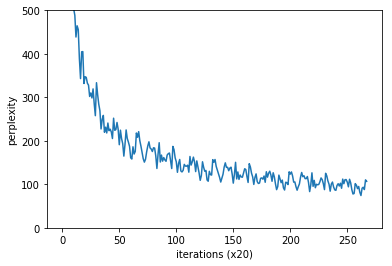

evaluating perplexity ...
0 / 235

1 / 235

2 / 235

3 / 235

4 / 235

5 / 235

6 / 235

7 / 235

8 / 235

9 / 235

10 / 235

11 / 235

12 / 235

13 / 235

14 / 235

15 / 235

16 / 235

17 / 235

18 / 235

19 / 235

20 / 235

21 / 235

22 / 235

23 / 235

24 / 235

25 / 235

26 / 235

27 / 235

28 / 235

29 / 235

30 / 235

31 / 235

32 / 235

33 / 235

34 / 235

35 / 235

36 / 235

37 / 235

38 / 235

39 / 235

40 / 235

41 / 235

42 / 235

43 / 235

44 / 235

45 / 235

46 / 235

47 / 235

48 / 235

49 / 235

50 / 235

51 / 235

52 / 235

53 / 235

54 / 235

55 / 235

56 / 235

57 / 235

58 / 235

59 / 235

60 / 235

61 / 235

62 / 235

63 / 235

64 / 235

65 / 235

66 / 235

67 / 235

68 / 235

69 / 235

70 / 235

71 / 235

72 / 235

73 / 235

74 / 235

75 / 235

76 / 235

77 / 235

78 / 235

79 / 235

80 / 235

81 / 235

82 / 235

83 / 235

84 / 235

85 / 235

86 / 235

87 / 235

88 / 235

89 / 235

90 / 235

91 / 235

92 / 235

93 / 235

94 / 235

95 / 235

96 / 235

97 / 235

98 / 235

99 / 235

100 / 235

101 / 235

102 / 235

103 / 235

104 / 235

105 / 235

106 / 235

107 / 235

108 / 235

109 / 235

110 / 235

111 / 235

112 / 235

113 / 235

114 / 235

115 / 235

116 / 235

117 / 235

118 / 235

119 / 235

120 / 235

121 / 235

122 / 235

123 / 235

124 / 235

125 / 235

126 / 235

127 / 235

128 / 235

129 / 235

130 / 235

131 / 235

132 / 235

133 / 235

134 / 235

135 / 235

136 / 235

137 / 235

138 / 235

139 / 235

140 / 235

141 / 235

142 / 235

143 / 235

144 / 235

145 / 235

146 / 235

147 / 235

148 / 235

149 / 235

150 / 235

151 / 235

152 / 235

153 / 235

154 / 235

155 / 235

156 / 235

157 / 235

158 / 235

159 / 235

160 / 235

161 / 235

162 / 235

163 / 235

164 / 235

165 / 235

166 / 235

167 / 235

168 / 235

169 / 235

170 / 235

171 / 235

172 / 235

173 / 235

174 / 235

175 / 235

176 / 235

177 / 235

178 / 235

179 / 235

180 / 235

181 / 235

182 / 235

183 / 235

184 / 235

185 / 235

186 / 235

187 / 235

188 / 235

189 / 235

190 / 235

191 / 235

192 / 235

193 / 235

194 / 235

195 / 235

196 / 235

197 / 235

198 / 235

199 / 235

200 / 235

201 / 235

202 / 235

203 / 235

204 / 235

205 / 235

206 / 235

207 / 235

208 / 235

209 / 235

210 / 235

211 / 235

212 / 235

213 / 235

214 / 235

215 / 235

216 / 235

217 / 235

218 / 235

219 / 235

220 / 235

221 / 235

222 / 235

223 / 235

224 / 235

225 / 235

226 / 235

227 / 235

228 / 235

229 / 235

230 / 235

231 / 235

232 / 235

233 / 235

234 / 235


test perplexity:  133.54493388362522


In [9]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from ch06.rnnlm import Rnnlm

batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25


corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

model.save_params()


In [3]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *
from common.base_model import BaseModel

class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 =  (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()
        


In [4]:
import sys
sys.path.append('..')
from common import config
config.GPU = True
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from ch06.better_rnnlm import BetterRnnlm

batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size, time_size=time_size, max_grad=max_grad)
    
    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('valid perplexity: ', ppl)
    
    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr
        model.reset_state()
        print('-' * 50)


Done


| epoch 1 |  iter 1 / 1327 | time 3[s] | perplexity 9999.76


| epoch 1 |  iter 21 / 1327 | time 46[s] | perplexity 3724.62


| epoch 1 |  iter 41 / 1327 | time 89[s] | perplexity 1828.47


| epoch 1 |  iter 61 / 1327 | time 133[s] | perplexity 1350.23


| epoch 1 |  iter 81 / 1327 | time 177[s] | perplexity 1011.69


| epoch 1 |  iter 101 / 1327 | time 222[s] | perplexity 852.33


| epoch 1 |  iter 121 / 1327 | time 265[s] | perplexity 805.63


| epoch 1 |  iter 141 / 1327 | time 309[s] | perplexity 742.84


| epoch 1 |  iter 161 / 1327 | time 352[s] | perplexity 688.21


| epoch 1 |  iter 181 / 1327 | time 395[s] | perplexity 695.76


| epoch 1 |  iter 201 / 1327 | time 439[s] | perplexity 600.95


| epoch 1 |  iter 221 / 1327 | time 482[s] | perplexity 570.60


| epoch 1 |  iter 241 / 1327 | time 526[s] | perplexity 521.01


| epoch 1 |  iter 261 / 1327 | time 570[s] | perplexity 550.75


| epoch 1 |  iter 281 / 1327 | time 613[s] | perplexity 517.27


| epoch 1 |  iter 301 / 1327 | time 665[s] | perplexity 457.53


| epoch 1 |  iter 321 / 1327 | time 712[s] | perplexity 398.57


| epoch 1 |  iter 341 / 1327 | time 763[s] | perplexity 449.55


| epoch 1 |  iter 361 / 1327 | time 819[s] | perplexity 467.38


| epoch 1 |  iter 381 / 1327 | time 867[s] | perplexity 384.96


| epoch 1 |  iter 401 / 1327 | time 920[s] | perplexity 402.51


| epoch 1 |  iter 421 / 1327 | time 969[s] | perplexity 392.92


| epoch 1 |  iter 441 / 1327 | time 1020[s] | perplexity 378.34


| epoch 1 |  iter 461 / 1327 | time 1073[s] | perplexity 367.76


| epoch 1 |  iter 481 / 1327 | time 1122[s] | perplexity 349.09


| epoch 1 |  iter 501 / 1327 | time 1173[s] | perplexity 351.67


| epoch 1 |  iter 521 / 1327 | time 1221[s] | perplexity 340.07


| epoch 1 |  iter 541 / 1327 | time 1269[s] | perplexity 360.67


| epoch 1 |  iter 561 / 1327 | time 1317[s] | perplexity 320.51


| epoch 1 |  iter 581 / 1327 | time 1366[s] | perplexity 288.76


| epoch 1 |  iter 601 / 1327 | time 1416[s] | perplexity 373.38


| epoch 1 |  iter 621 / 1327 | time 1460[s] | perplexity 343.21


| epoch 1 |  iter 641 / 1327 | time 1504[s] | perplexity 312.36


| epoch 1 |  iter 661 / 1327 | time 1547[s] | perplexity 296.73


| epoch 1 |  iter 681 / 1327 | time 1591[s] | perplexity 254.30


| epoch 1 |  iter 701 / 1327 | time 1635[s] | perplexity 280.04


| epoch 1 |  iter 721 / 1327 | time 1678[s] | perplexity 288.53


| epoch 1 |  iter 741 / 1327 | time 1722[s] | perplexity 250.13


| epoch 1 |  iter 761 / 1327 | time 1766[s] | perplexity 260.51


| epoch 1 |  iter 781 / 1327 | time 1810[s] | perplexity 243.17


| epoch 1 |  iter 801 / 1327 | time 1854[s] | perplexity 267.65


| epoch 1 |  iter 821 / 1327 | time 1898[s] | perplexity 251.04


| epoch 1 |  iter 841 / 1327 | time 1942[s] | perplexity 257.28


| epoch 1 |  iter 861 / 1327 | time 1986[s] | perplexity 249.99


| epoch 1 |  iter 881 / 1327 | time 2030[s] | perplexity 230.83


| epoch 1 |  iter 901 / 1327 | time 2074[s] | perplexity 281.44


| epoch 1 |  iter 921 / 1327 | time 2118[s] | perplexity 254.84


| epoch 1 |  iter 941 / 1327 | time 2162[s] | perplexity 256.45


| epoch 1 |  iter 961 / 1327 | time 2205[s] | perplexity 273.40


| epoch 1 |  iter 981 / 1327 | time 2249[s] | perplexity 257.50


| epoch 1 |  iter 1001 / 1327 | time 2292[s] | perplexity 215.75


| epoch 1 |  iter 1021 / 1327 | time 2336[s] | perplexity 250.57


| epoch 1 |  iter 1041 / 1327 | time 2379[s] | perplexity 230.77


| epoch 1 |  iter 1061 / 1327 | time 2423[s] | perplexity 219.20


| epoch 1 |  iter 1081 / 1327 | time 2466[s] | perplexity 187.05


| epoch 1 |  iter 1101 / 1327 | time 2510[s] | perplexity 213.55


| epoch 1 |  iter 1121 / 1327 | time 2553[s] | perplexity 253.26


| epoch 1 |  iter 1141 / 1327 | time 2599[s] | perplexity 229.29


| epoch 1 |  iter 1161 / 1327 | time 2648[s] | perplexity 221.59


| epoch 1 |  iter 1181 / 1327 | time 2698[s] | perplexity 209.37


| epoch 1 |  iter 1201 / 1327 | time 2747[s] | perplexity 180.44


| epoch 1 |  iter 1221 / 1327 | time 2796[s] | perplexity 179.70


| epoch 1 |  iter 1241 / 1327 | time 2839[s] | perplexity 208.13


| epoch 1 |  iter 1261 / 1327 | time 2882[s] | perplexity 191.20


| epoch 1 |  iter 1281 / 1327 | time 2925[s] | perplexity 197.12


| epoch 1 |  iter 1301 / 1327 | time 2968[s] | perplexity 246.53


| epoch 1 |  iter 1321 / 1327 | time 3011[s] | perplexity 233.48


evaluating perplexity ...


0 / 210

1 / 210

2 / 210

3 / 210

4 / 210

5 / 210

6 / 210

7 / 210

8 / 210

9 / 210

10 / 210

11 / 210

12 / 210

13 / 210

14 / 210

15 / 210

16 / 210

17 / 210

18 / 210

19 / 210

20 / 210

21 / 210

22 / 210

23 / 210

24 / 210

25 / 210

26 / 210

27 / 210

28 / 210

29 / 210

30 / 210

31 / 210

32 / 210

33 / 210

34 / 210

35 / 210

36 / 210

37 / 210

38 / 210

39 / 210

40 / 210

41 / 210

42 / 210

43 / 210

44 / 210

45 / 210

46 / 210

47 / 210

48 / 210

49 / 210

50 / 210

51 / 210

52 / 210

53 / 210

54 / 210

55 / 210

56 / 210

57 / 210

58 / 210

59 / 210

60 / 210

61 / 210

62 / 210

63 / 210

64 / 210

65 / 210

66 / 210

67 / 210

68 / 210

69 / 210

70 / 210

71 / 210

72 / 210

73 / 210

74 / 210

75 / 210

76 / 210

77 / 210

78 / 210

79 / 210

80 / 210

81 / 210

82 / 210

83 / 210

84 / 210

85 / 210

86 / 210

87 / 210

88 / 210

89 / 210

90 / 210

91 / 210

92 / 210

93 / 210

94 / 210

95 / 210

96 / 210

97 / 210

98 / 210

99 / 210

100 / 210

101 / 210

102 / 210

103 / 210

104 / 210

105 / 210

106 / 210

107 / 210

108 / 210

109 / 210

110 / 210

111 / 210

112 / 210

113 / 210

114 / 210

115 / 210

116 / 210

117 / 210

118 / 210

119 / 210

120 / 210

121 / 210

122 / 210

123 / 210

124 / 210

125 / 210

126 / 210

127 / 210

128 / 210

129 / 210

130 / 210

131 / 210

132 / 210

133 / 210

134 / 210

135 / 210

136 / 210

137 / 210

138 / 210

139 / 210

140 / 210

141 / 210

142 / 210

143 / 210

144 / 210

145 / 210

146 / 210

147 / 210

148 / 210

149 / 210

150 / 210

151 / 210

152 / 210

153 / 210

154 / 210

155 / 210

156 / 210

157 / 210

158 / 210

159 / 210

160 / 210

161 / 210

162 / 210

163 / 210

164 / 210

165 / 210

166 / 210

167 / 210

168 / 210

169 / 210

170 / 210

171 / 210

172 / 210

173 / 210

174 / 210

175 / 210

176 / 210

177 / 210

178 / 210

179 / 210

180 / 210

181 / 210

182 / 210

183 / 210

184 / 210

185 / 210

186 / 210

187 / 210

188 / 210

189 / 210

190 / 210

191 / 210

192 / 210

193 / 210

194 / 210

195 / 210

196 / 210

197 / 210

198 / 210

199 / 210

200 / 210

201 / 210

202 / 210

203 / 210

204 / 210

205 / 210

206 / 210

207 / 210

208 / 210

209 / 210


valid perplexity:  196.01494109724896


ValueError: operands could not be broadcast together with shapes (20,2600) (10,2600) 

In [2]:
# coding: utf-8
import sys
sys.path.append('..')
from common import config
# GPUで実行する場合は下記のコメントアウトを消去（要cupy）
# ==============================================
config.GPU = True
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from ch06.better_rnnlm import BetterRnnlm


# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('valid perplexity: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# テストデータでの評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)


ModuleNotFoundError: No module named 'cupy'